# **TikTok Project**
**Course 6 - The Nuts and bolts of machine learning**

Recall that you are a data professional at TikTok. Your supervisor was impressed with the work you have done and has requested that you build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

A notebook was structured and prepared to help you in this project. A notebook was structured and prepared to help you in this project. Please complete the following questions.

# **Course 6 End-of-course project: Classifying videos using machine learning**

In this activity, you will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

Follow the instructions and answer the questions below to complete the activity. Then, you will complete an Executive Summary using the questions listed on the PACE Strategy Document.

Be sure to complete this activity before moving on. The next course item will provide you with a completed exemplar to compare to your own work.



# **Classify videos using machine learning**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:


1.   **What are you being asked to do? What metric should I use to evaluate success of my business/organizational objective?**

2.   **What are the ethical implications of the model? What are the consequences of your model making errors?**
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?

  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)?

3.   **How would you proceed?**


Question 1:

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

Question 2:

In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

Question 3:

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set


### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [ ]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

Now load the data from the provided csv file into a dataframe.

**Note:** As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

<img src="images/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**

Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

Get the data types of the columns.

In [5]:
# Get data types of columns
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Get basic information about the dataset.

In [7]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [8]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [11]:
# Check for missing values
if(data.isna().sum().sum() == 0):
    print('\nThere are no missing values in the data set')
else:
    print('\nThere are',data.isna().sum().sum(),'missing values in the data set')
    print('\n')
    print(data.isna().sum())


There are 2086 missing values in the data set


#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64


In [13]:
# Drop rows with missing values
data = data.dropna(axis = 0)

# Check for missing values
if(data.isna().sum().sum() == 0):
    print('\nThere are no missing values in the data set')
else:
    print('\nThere are',data.isna().sum().sum(),'missing values in the data set')
    print('\n')
    print(data.isna().sum())


There are no missing values in the data set


In [14]:
# Display first few rows after handling missing values
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Check for and handle duplicates.

In [16]:
# Check for duplicates
# Check for missing values
if(data.duplicated().sum() == 0):
    print('\nThere are no duplicate values in the data set')
else:
    print('\nThere are',data.duplicated().sum(),'duplicate values in the data set')
    print('\n')


There are no duplicate values in the data set


Check for and handle outliers.

Check class balance.

In [18]:
# Check class balance
### YOUR CODE HERE ###
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [19]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [20]:
# Calculate the average text_length for claims and opinions
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions.

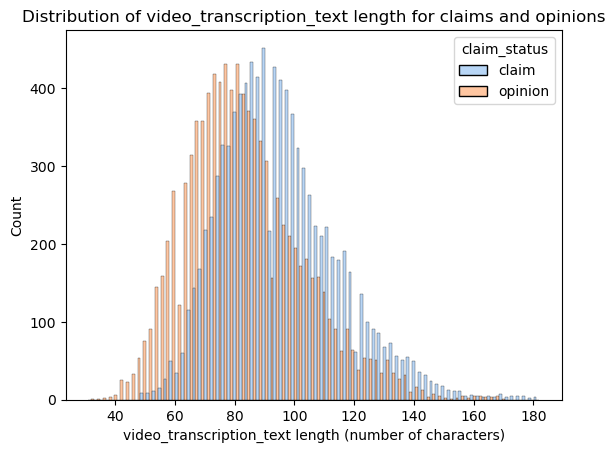

In [21]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

**Feature selection and transformation**

Encode target and catgorical variables.

In [22]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'],drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4: Split the data**

Assign target variable.

In [23]:
# Isolate target variable

y = X['claim_status']

Isolate the features.

In [24]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [25]:
# Split the data into training and testing sets

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [26]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=30)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [28]:
# Get shape of each training, validation, and testing set

print('\nshapes of train, validation and test data sets:\n')

print("X_train",X_train.shape)
print("y_train",y_train.shape)  
print('\n')
print("X_val",X_val.shape)
print("y_val",y_val.shape)
print('\n')
print("X_test",X_test.shape)
print("y_test",y_test.shape)


shapes of train, validation and test data sets:

X_train (11450, 11)
y_train (11450,)


X_val (3817, 11)
y_val (3817,)


X_test (3817, 11)
y_test (3817,)


In [35]:
#Convert String data to float

# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [36]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague learned,colleague read,discussion board,forum claim,friend learned,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,484250.0,55832.0,16344.0,644.0,134.0,86,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,59,5952.0,2114.0,289.0,6.0,2.0,82,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,39,6845.0,2144.0,583.0,13.0,1.0,107,False,True,False,...,0,0,0,0,0,0,1,0,0,0
3,48,1901.0,605.0,146.0,14.0,3.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,24,6580.0,3855.0,847.0,60.0,24.0,103,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [40]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague learned,colleague read,discussion board,forum claim,friend learned,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,41,686.0,10.0,2.0,0.0,0.0,71,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,18,9329.0,2360.0,677.0,12.0,0.0,72,False,False,True,...,0,0,0,0,0,0,0,0,0,0
2,48,5258.0,2078.0,685.0,6.0,2.0,63,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,37,6208.0,377.0,132.0,9.0,2.0,69,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,24,8728.0,3838.0,947.0,50.0,10.0,55,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,14,755569.0,484643.0,3205.0,11268.0,5513.0,67,False,False,True,...,0,0,0,0,0,0,0,0,0,0
1,45,778.0,9.0,3.0,0.0,0.0,79,True,False,False,...,0,0,0,0,0,0,1,0,0,0
2,8,7705.0,580.0,14.0,11.0,3.0,55,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,29,181276.0,4422.0,382.0,45.0,12.0,89,False,False,True,...,0,0,0,0,0,0,0,0,0,0
4,29,1437.0,613.0,40.0,8.0,3.0,85,False,False,False,...,0,0,0,0,0,0,1,0,0,0


### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [33]:
# Instantiate the random forest classifier
RF_MODEL = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
RF_PARAMS = {'n_estimators' : [50,100], 
              'max_depth' : [10,50],        
              'min_samples_leaf' : [0.5,1], 
              'min_samples_split' : [0.001, 0.01],
              'max_features' : ["sqrt"], 
              'max_samples' : [.5,.9]}

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
RF_GRID = GridSearchCV(RF_MODEL, RF_PARAMS, scoring=scoring, cv=5, refit='recall')

In [43]:
# Examine best recall score

RF_GRID.fit(X_train_final,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 50], 'max_features': ['sqrt'],
                         'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [0.5, 1],
                         'min_samples_split': [0.001, 0.01],
                         'n_estimators': [50, 100]},
             refit='recall', scoring={'recall', 'f1', 'accuracy', 'precision'})

In [47]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table


results = make_results('RANDOM FOREST CV', RF_GRID, 'f1')

results.style.set_properties(**{'border': '1.3px solid black','color': 'blue'})

,model,precision,recall,F1,accuracy
0,RANDOM FOREST CV,0.999827,0.995853,0.997835,0.997817


In [49]:
# Examine best parameters
RF_GRID.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 0.5,
 'min_samples_split': 0.001,
 'n_estimators': 50}

**Question:** How well is your model performing? Consider average recall score and precision score.

- Model is over fitting the data, as average recall score and precision score is almost 1

### **Build an XGBoost model**

In [50]:
# Instantiate the XGBoost classifier
XGB_MODEL = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
XGB_PARAMS = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
XGB_GRID = GridSearchCV(XGB_MODEL, XGB_PARAMS, scoring=scoring, cv=5, refit='recall')

In [51]:
XGB_GRID.fit(X_train_final,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'recall', 'f1', 'accuracy', 'precision'})

In [57]:
results1 = make_results('XGB GRID CV', XGB_GRID, 'f1')

results1.columns = results.columns

results = pd.concat([results, results1], ignore_index=True)

results.style.set_properties(**{'border': '1.3px solid black','color': 'blue'})

,model,precision,recall,F1,accuracy
0,RANDOM FOREST CV,0.999827,0.995853,0.997835,0.997817
1,XGB GRID CV,0.999826,0.990497,0.995138,0.995109


**Question:** How well does your model perform? Consider recall score and precision score.

Model is fitting almost all the data provided with a recall and precision of 1

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [58]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = RF_GRID.best_estimator_.predict(X_val_final)

Display the predictions on the encoded testing set.

In [59]:
# Display the predictions on the encoded testing set
y_pred

array([1, 1, 1, ..., 1, 1, 1])

Display the true labels of the testing set.

In [60]:
# Display the true labels of the testing set
y_val

17656    0
13919    0
14285    0
14564    0
12537    0
        ..
8186     1
16787    0
11986    0
17989    0
14634    0
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

<Axes: >

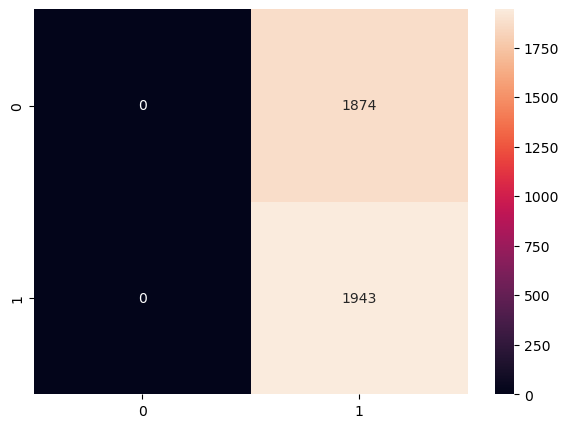

In [61]:
# Generate array of values for confusion matrix

CM = metrics.confusion_matrix(y_val, y_pred)

CM_DF = pd.DataFrame(CM, index = [i for i in RF_GRID.classes_],
                  columns = [i for i in RF_GRID.classes_])

plt.figure(figsize = (7,5))

sns.heatmap(CM_DF, annot=True ,fmt='g')

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [62]:
# Create a classification report
# Create classification report for random forest model

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1874
           1       0.51      1.00      0.67      1943

    accuracy                           0.51      3817
   macro avg       0.25      0.50      0.34      3817
weighted avg       0.26      0.51      0.34      3817



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Question:** What does your classification report show? What does the confusion matrix indicate?

#### **XGBoost**

In [63]:
#Evaluate XGBoost model
y_pred_x = XGB_GRID.best_estimator_.predict(X_val_final)

<Axes: >

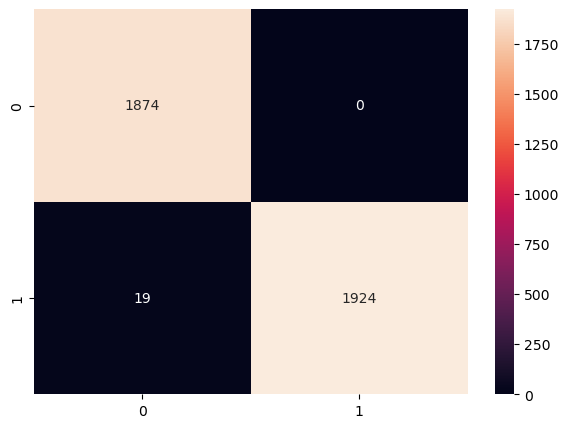

In [64]:
# Generate array of values for confusion matrix

CM = metrics.confusion_matrix(y_val, y_pred_x)

CM_DF = pd.DataFrame(CM, index = [i for i in XGB_GRID.classes_],
                  columns = [i for i in XGB_GRID.classes_])

plt.figure(figsize = (7,5))

sns.heatmap(CM_DF, annot=True ,fmt='g')

In [66]:
# Create a classification report
print(classification_report(y_val,y_pred_x))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1874
           1       1.00      0.99      1.00      1943

    accuracy                           1.00      3817
   macro avg       0.99      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

-- Compared to Random Forest, XGB is giving better results as the random forest is classifying all the data as positives where as XGB is performing better

### **Use champion model to predict on test data**

In [67]:
### YOUR CODE HERE ###

y_pred_final = XGB_GRID.predict(X_test_final)

y_pred_final

array([1, 0, 0, ..., 0, 0, 1])

<Axes: >

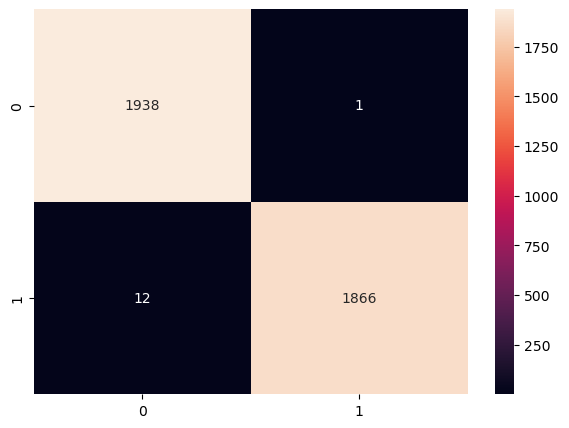

In [68]:
# Generate array of values for confusion matrix

CM = metrics.confusion_matrix(y_test, y_pred_final)

CM_DF = pd.DataFrame(CM, index = [i for i in XGB_GRID.classes_],
                  columns = [i for i in XGB_GRID.classes_])

plt.figure(figsize = (7,5))

sns.heatmap(CM_DF, annot=True ,fmt='g')

#### **Feature importances of champion model**


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

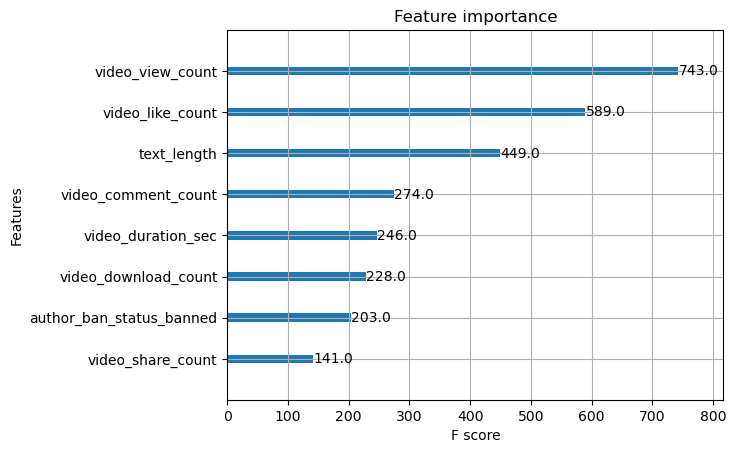

In [69]:
### YOUR CODE HERE ###

plot_importance(XGB_GRID.best_estimator_)

**Question:** Describe your most predictive features. Were your results surprising?

### **Task 8. Conclusion**

In this step use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**

2. **What was your model doing? Can you explain how it was making predictions?**

3. **Are there new features that you can engineer that might improve model performance?**

4. **What features would you want to have that would likely improve the performance of your model?**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


1. I recommend XGB model over Random Forest as it is giving better results
2. The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
3. Because the model currently performs nearly perfectly, there is no need to engineer any new features.
4. The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.